In [167]:
import numpy as np
import pandas as pd
import scipy.linalg
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import requests
import time
import plotly.graph_objects as go
from plotly.offline import iplot

## Notes for improvement: 

Need to learn how to deal with delisted names

Need to use adj close prices, not close prices

Implement the randomized linear algebra stuff (look into Marchenko-Pastur bound)

### Rangle data

In [2]:
def download_to_master_csv(tickers, start, end,
                           out_dir="data/daily",
                           master_csv="data/daily/master_all.csv",
                           batch_size=200,
                           pause=0.01):
    import os, time, yfinance as yf
    from tqdm import tqdm

    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(os.path.dirname(master_csv), exist_ok=True)

    # overwrite existing master
    if os.path.exists(master_csv):
        os.remove(master_csv)

    tickers = list(tickers)
    write_header = True

    for i in range(0, len(tickers), batch_size):
        batch = tickers[i : i + batch_size]
        for t in tqdm(batch, desc=f"batch {i//batch_size+1}"):
            try:
                df = yf.download(t, start=start, end=end, progress=False, threads=False)
                if df.empty:
                    time.sleep(pause)
                    continue
                # ensure date index and columns normalized
                df = df.reset_index()
                df['Ticker'] = t
                # write to master CSV (append mode)
                df.to_csv(master_csv, mode='a', header=write_header, index=False)
                write_header = False
                time.sleep(pause)
            except Exception as e:
                print(f"failed {t}: {e}")
                time.sleep(pause)


def load_master_csv(master_csv="data/daily/master_all.csv",
                    parse_dates=["Date"],
                    set_multiindex=True):
    import pandas as pd
    df = pd.read_csv(master_csv, parse_dates=parse_dates)
    if set_multiindex:
        df = df.set_index(["Date", "Ticker"]).sort_index()
    return df


In [118]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
}

response = requests.get(url, headers=headers)
response.raise_for_status()   # ensures no silent failures

tables = pd.read_html(response.text)
sp500 = tables[1]

tickers = ["SPY"] + sp500['Symbol'].tolist()
tickers = [t.replace('.', '-') for t in tickers]  # yfinance fix

print(len(tickers))
print(tickers[:10])


503
['SPY', 'MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL']


/var/folders/kv/8y99vq713_b3nk5wm2frwqsm0000gn/T/ipykernel_86515/3536039600.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [4]:
# download_to_master_csv(tickers,start="2000-01-01",end="2024-06-01")

In [119]:
# or, starting from a flat DataFrame:
df = pd.read_csv("data/daily/master_all.csv", parse_dates=['Date'])


/var/folders/kv/8y99vq713_b3nk5wm2frwqsm0000gn/T/ipykernel_86515/1375286159.py:2: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/daily/master_all.csv", parse_dates=['Date'])


In [159]:
data = df.set_index(["Date", "Ticker"]).copy()
data = data.iloc[1:,:] #Needed if using all data, but not if skipping to start at 20XX - issue with file load in, too much data to edit csv directly. 
data = data.apply(pd.to_numeric, errors='coerce')
data['Daily Log Return'] = np.log(data['Close']).groupby('Ticker').diff()
# data.dropna(inplace=True)

data.sort_index(inplace=True)
# data = data.loc[pd.IndexSlice['2020-01-01':,:], :]
data.head(), data.shape

(                       Close       High        Low       Open     Volume  \
 Date       Ticker                                                          
 2000-01-03 A       43.113312  47.267457  40.343878  47.155182    4674353   
            AAPL     0.839281   0.843498   0.762429   0.786328  535796800   
            ABT      8.134056   8.366458   8.075956   8.192157   10635087   
            ACGL     1.215037   1.347107   1.201830   1.340503     433800   
            ADBE    16.274668  16.755616  15.948864  16.693558    7384400   
 
                    Daily Log Return  
 Date       Ticker                    
 2000-01-03 A                    NaN  
            AAPL                 NaN  
            ABT                  NaN  
            ACGL                 NaN  
            ADBE                 NaN  ,
 (2691580, 6))

In [195]:
data_no_spy = data.drop(index='SPY', level='Ticker')

log_rets_noSPY = data_no_spy['Daily Log Return'].unstack('Ticker').iloc[1:,:]

log_rets_noSPY.head(), log_rets_noSPY.shape

(Ticker             A      AAPL       ABT      ACGL      ADBE       ADI  \
 Date                                                                     
 2000-01-04 -0.079464 -0.088077 -0.028988 -0.005450 -0.087618 -0.051913   
 2000-01-05 -0.064038  0.014527 -0.001840  0.088831  0.019578  0.014492   
 2000-01-06 -0.038820 -0.090514  0.034392 -0.010050  0.008130 -0.027719   
 2000-01-07  0.080043  0.046281  0.010620  0.054067  0.047440  0.027719   
 2000-01-10  0.058813 -0.017744 -0.007067  0.032944  0.037883  0.083468   
 
 Ticker           ADM       ADP      ADSK       AEE  ...  EXE  COIN  APP  HOOD  \
 Date                                                ...                         
 2000-01-04 -0.010471  0.000000 -0.049915  0.000000  ...  NaN   NaN  NaN   NaN   
 2000-01-05 -0.015916 -0.009662 -0.065063  0.037955  ...  NaN   NaN  NaN   NaN   
 2000-01-06  0.005333  0.013261 -0.062859 -0.003732  ...  NaN   NaN  NaN   NaN   
 2000-01-07  0.015832  0.022499  0.112050  0.014843  ...  NaN  

### First, generate residuals by regressing on PCA portfolio
Use 15 principle components, following the paper's best for now

Lookback of 3 years since we have 500x500 points to estimate

In future: build in some checks on when eigenvalues are pure noise (Marchenko-Pastur). GPT had good stuff on this (currently at the bottom of the Recreate Stat Arb in Python thread)
    
Paper uses "Take top k components, hard cutoff across time" and "Take k st X% of the total variance is explained"

I think "Take lower of k (hard cutoff) and Y st all Y components are distinguishable from noise" is probably already taken care of in the paper, but worth checking. Can see how much data is typically needed to get k stable components and then find a lower bound to allow for more adaptability to recent events in the k (hard cutoff) method
            
Can't do the same for the X% variance explained, as the number of components needed to explain X% varies greatly with current volatility in the market. We know that higher vol => less components needed for X% explain variance, as a few big movers drive the market, and similarly more needed when vol is low as the variance is less concentrated. I wonder if the same is actually true for k stable or not. Could very well be that as recent data is less stable you need more of it to get same amount of component stability, I am unsure how noticible the difference could be. 

In [196]:
def calculate_pca_factors(log_rets_noSPY, num_pc, lookback_period):
    """
    Optimized version of PCA factor calculation.
    """
    # 1. Prepare Data Containers
    # Extract only the stock columns (exclude existing 'eig' columns if any)
    stock_cols = log_rets_noSPY.columns[:-num_pc] if f"eig{num_pc}" in log_rets_noSPY.columns else log_rets_noSPY.columns
    
    # Convert to numpy for speed
    data_values = log_rets_noSPY[stock_cols].values
    dates = log_rets_noSPY.index
    n_days, n_stocks = data_values.shape
    
    # Pre-allocate output array for the factors
    # We only calculate factors starting from 'lookback_period'
    factor_returns = np.full((n_days, num_pc), np.nan)
    
    # 2. Main Loop
    # We iterate through indices, starting from lookback_period
    # range logic: we need 'lookback_period' rows previous to t.
    
    for t_idx in range(lookback_period, n_days):
        
        # Slicing numpy arrays is instant (view, not copy)
        # Window: [t - lookback : t]
        # drop any stocks with nan data within the window
        window = data_values[t_idx - lookback_period : t_idx]
        has_nan_in_window = np.isnan(window).any(axis=0)
        clean_window = window[:,~has_nan_in_window]
        n_stocks = clean_window.shape[1]

        # --- Step A: Studentize (Standardize) ---
        # Calculate mean/std along axis 0 (time)
        means = np.mean(clean_window, axis=0)
        stds = np.std(clean_window, axis=0, ddof=1) # ddof=1 to match Pandas std() default
        
        # Handle division by zero edge case
        stds[stds == 0] = 1.0
        
        studentized = (clean_window - means) / stds
        
        # --- Step B: Correlation Matrix ---
        # (X.T @ X) / (N - 1)
        corr_matrix = (studentized.T @ studentized) / (lookback_period - 1)
        
        # --- Step C: Partial Eigen Decomposition ---
        # SCIPY OPTIMIZATION:
        # Instead of calculating ALL eigenvectors (slow), we only ask for the top 'num_pc'.
        # subset_by_index takes range [min, max]. 
        # Since eigh returns ascending eigenvalues, the top K are indices [N-K, N-1].
        subset_range = (n_stocks - num_pc, n_stocks - 1)
        
        try:
            # check_finite=False saves a tiny bit of time if we know data is clean
            eigenvalues, eigenvectors = scipy.linalg.eigh(
                corr_matrix, 
                subset_by_index=subset_range
            )
        except np.linalg.LinAlgError:
            # Fallback for singular matrices (rare in returns data)
            continue

        # Scipy returns them in ascending order, so we flip them to be Descending
        # Shape: (n_stocks, num_pc)
        sorted_vectors = eigenvectors[:, ::-1]
        
        # --- Step D: Normalization (Matching Original Logic) ---
        # Normalize by L1 norm (sum of abs values)
        col_abs_sums = np.sum(np.abs(sorted_vectors), axis=0)
        col_abs_sums[col_abs_sums == 0] = 1.0 # Safety
        
        # Apply L1 norm normalization
        # Then divide by standard deviation (as per original code logic)
        # Note: The original code divides the *eigenvectors* by the *stds* of the returns.
        # This effectively scales the "weights" to be applied to raw returns.
        
        # Broadcast division: (Stocks, PC) / (1, PC) / (Stocks, 1)
        raw_weights = (sorted_vectors / col_abs_sums) / stds[:, np.newaxis]
        
        # --- Step E: Calculate Factor Return for the current day ---
        # Factor Return = Weights.T @ Current_Day_Returns
        current_day_ret = data_values[t_idx] # Shape (n_stocks,)
        current_day_ret_clean = current_day_ret[~has_nan_in_window]
        
        # (num_pc, n_stocks) @ (n_stocks,) -> (num_pc,)
        daily_factor_rets = raw_weights.T @ current_day_ret_clean
        
        factor_returns[t_idx] = daily_factor_rets

    # 3. Save back to DataFrame
    # Create column names
    eig_col_names = [f"eig{i+1}" for i in range(num_pc)]
    
    # Assign columns efficiently
    # We use a temporary DF to align indices before assignment if necessary, 
    # but since we kept alignment 1:1 with log_rets_noSPY, we can assign directly.
    log_rets_noSPY[eig_col_names] = factor_returns
    
    return log_rets_noSPY

In [197]:
l_win_PCA = 252
n_pc = 15
log_rets_noSPY = calculate_pca_factors(log_rets_noSPY, n_pc, l_win_PCA)
# number of stocks in analysis starts at 349 and ends at 498!! Big improvement. 

### Perform Backtest 
Using method from Avellanda and Lee 

- same trading rules, not re-datamined from current data

In [199]:
def Avellanda_Lee_backtest(returns, num_pc, l_win, s_win, transaction_cost_rate = 0.001):
    """
    Optimized version of n_pca_portfolio with transaction costs included, 
    and robust NaN handling to avoid survivorship bias.
    
    :param returns: DataFrame of log returns including stock and factor columns.
    :param num_pc: Number of principal components (factors).
    :param l_win: Long lookback window (start index synchronization).
    :param s_win: Short lookback window (OU parameter estimation).
    :param transaction_cost_rate: Cost per $1 traded (e.g., 0.0001 for 1bp).
    :return: Daily net returns and S-scores DataFrame.
    """
    
    # 1. Data Preparation
    # Separate stock returns (Y) and factor returns (X)
    stock_cols = returns.columns[:-num_pc]
    factor_cols = returns.columns[-num_pc:]
    
    Y_full = returns[stock_cols].values
    X_full = returns[factor_cols].values
    
    # Indices/Dates to iterate over
    start_idx = l_win
    n_days = len(returns)
    valid_indices = np.arange(start_idx, n_days)
    dates = returns.index[start_idx:]
    
    n_stocks = len(stock_cols)
    
    # 2. Pre-allocate Output Containers
    s_scores_data = np.full((len(dates), n_stocks), np.nan)
    # Store betas: (Time, Stocks, Num_PC)
    betas_storage = np.zeros((len(dates), n_stocks, num_pc))
    
    # --- Main Loop (OU Parameter & Signal Generation) ---
    for i, t_idx in enumerate(valid_indices):
        # Define window indices
        win_start = t_idx - s_win + 1
        win_end = t_idx + 1 
        
        # Extract windows
        Y_win = Y_full[win_start:win_end].copy() 
        X_win = X_full[win_start:win_end]      
        
        # --- FIX FOR SURVIVORSHIP BIAS / NaN HANDLING ---
        # Identify stocks that have ANY NaN in the current s_win window.
        has_nan_in_window = np.isnan(Y_win).any(axis=0)
        
        # Only proceed with stocks that have a complete history in the s_win window
        Y_win_complete = Y_win[:, ~has_nan_in_window]
        n_stocks_complete = Y_win_complete.shape[1]
        
        # If no stocks are valid in the window, skip this day
        if n_stocks_complete == 0:
            continue
        
        # --- Regression 1: Stocks ~ Factors (Calculate Betas) ---
        s_win_inner = Y_win_complete.shape[0] 
        X_design = np.column_stack([np.ones(s_win_inner), X_win])
        
        try:
            # Fit only on the RAW Y_win_complete (not normalized)
            B_all_complete, _, _, _ = np.linalg.lstsq(X_design, Y_win_complete, rcond=None)
        except np.linalg.LinAlgError:
            continue
        
        # Store results back into the full-size arrays using a mask
        current_betas = np.zeros((n_stocks, num_pc))
        current_betas[~has_nan_in_window, :] = B_all_complete[1:, :].T
        betas_storage[i] = current_betas
        
        # Calculate Residuals (Epsilon)
        # E = Y_norm - (X_design @ B_norm)
        # We use the Betas from the raw regression, scaled by the standard deviation of Y
        epsilon_complete = Y_win_complete - (X_design @ B_all_complete)


        # --- Regression 2: OU Process on Cumulative Residuals (on complete subset) ---
        aux = np.cumsum(epsilon_complete, axis=0)
        x_lag = aux[:-1, :]
        y_curr = aux[1:, :]
        
        # Vectorized Simple Linear Regression (Y ~ a + bX)
        N_lag = s_win_inner - 1
        sum_x = np.sum(x_lag, axis=0)
        sum_y = np.sum(y_curr, axis=0)
        sum_xy = np.sum(x_lag * y_curr, axis=0)
        sum_xx = np.sum(x_lag**2, axis=0)
        
        # Slope (b)
        denom = (N_lag * sum_xx - sum_x**2)
        valid_denom = np.abs(denom) > 1e-8
        
        # Initialize full size arrays for the coefficients (important for consistent indexing)
        b_coef_full = np.full(n_stocks, np.nan)
        a_coef_full = np.full(n_stocks, np.nan)
        var_zeta_full = np.full(n_stocks, np.nan)
        
        # Calculate coefficients only for valid denominators in the complete subset
        b_coef_complete = np.full(n_stocks_complete, np.nan)
        b_coef_complete[valid_denom] = (N_lag * sum_xy[valid_denom] - sum_x[valid_denom] * sum_y[valid_denom]) / denom[valid_denom]
        
        a_coef_complete = (sum_y - b_coef_complete * sum_x) / N_lag
        zeta = y_curr - (a_coef_complete + b_coef_complete * x_lag)
        var_zeta_complete = np.var(zeta, axis=0)

        # Map results back to the full n_stocks array for consistent indices
        b_coef_full[~has_nan_in_window] = b_coef_complete
        a_coef_full[~has_nan_in_window] = a_coef_complete
        var_zeta_full[~has_nan_in_window] = var_zeta_complete
        
        # --- OU Parameters & Filtering (using full arrays) ---
        kappa = np.full(n_stocks, np.nan)
        valid_b_log = (b_coef_full > 0)
        kappa[valid_b_log] = -np.log(b_coef_full[valid_b_log]) * 252
        
        sigma_eq = np.full(n_stocks, np.nan)
        valid_sigma = (1 - b_coef_full**2) > 0
        sigma_eq[valid_sigma] = np.sqrt(var_zeta_full[valid_sigma] / (1 - b_coef_full[valid_sigma]**2))
        
        m = a_coef_full / (1 - b_coef_full)
        
        # Filter Logic (applied to full arrays)
        mask_valid = (
            (b_coef_full > 0) & 
            (b_coef_full < 0.9672) & 
            (kappa > (252.0 / 30.0))
        )
        
        # Calculate m_bar
        m_values = m.copy()
        m_values[~mask_valid] = np.nan 
        
        m_bar_series = m_values - np.nanmean(m_values)
        
        # Calculate s-score
        s_scores = -m_bar_series / sigma_eq
        
        # Apply final validity mask to scores
        s_scores[~mask_valid] = np.nan
        
        # Store
        s_scores_data[i, :] = s_scores

    # Create DataFrame for S-scores
    s_scores_df = pd.DataFrame(s_scores_data, index=dates, columns=stock_cols)
    
    # 4. Signal Generation & Backtesting
    positions_data = np.zeros((len(dates), n_stocks))
    current_pos = np.zeros(n_stocks)
    s_vals = s_scores_df.values
    
    for i in range(len(dates)):
        scores = s_vals[i]
        
        # The logic here handles NaN: any stock with NaN score will fail the threshold check
        open_short = (scores > 1.25)
        open_long = (scores < -1.25)
        
        close_short = (current_pos == -1) & (scores < 0.75)
        close_long = (current_pos == 1) & (scores > -0.5)
                
        # Update positions. Order matters: entry takes precedence over exit on the same day.
        current_pos[open_short] = -1
        current_pos[open_long] = 1
        
        current_pos[close_short] = 0
        current_pos[close_long] = 0
        
        # Store
        positions_data[i] = current_pos.copy()
        
    algo_weights = pd.DataFrame(positions_data, index=dates, columns=stock_cols)
    
    # 5. Weighting (Equal Capital Allocation)
    long_mask = algo_weights > 0
    short_mask = algo_weights < 0
    
    # Summing across axis=1 ignores NaNs, which is correct for counts
    long_counts = long_mask.sum(axis=1)
    short_counts = short_mask.sum(axis=1)
    
    # Division on subsets works correctly with NaNs. fillna(0) prevents issues if no long/short exists.
    algo_weights[long_mask] = algo_weights[long_mask].div(long_counts, axis=0).fillna(0)
    algo_weights[short_mask] = algo_weights[short_mask].div(short_counts, axis=0).fillna(0)
    
    # 6. PCA Portfolio Exposure Calculation
    w_values = algo_weights.values
    
    # Calculate hedge exposure: (Time, Stocks) @ (Time, Stocks, Factors) -> (Time, Factors)
    hedge_exposures = -np.einsum('ij,ijk->ik', w_values, betas_storage)
    
    # Add factor weights to algo_weights DataFrame
    eig_cols = [f"eig{i+1}" for i in range(num_pc)]
    algo_weights[eig_cols] = hedge_exposures
    
    # 7. Final Returns and Transaction Cost Calculation
    
    ret_subset = returns.iloc[l_win+1:] 
    
    # Weights calculated at T (algo_weights) are used for T+1 return (w_shifted)
    w_t_minus_1 = algo_weights.shift(1).fillna(0) # Weights at t-1 (yesterday's close)
    w_t = algo_weights # Weights at t (today's close)

    # Align indices for T-1 weights
    w_t_minus_1 = w_t_minus_1.reindex(ret_subset.index)
    w_t = w_t.reindex(ret_subset.index)
    
    # A. Calculate Position Change (Turnover)
    position_change = (w_t - w_t_minus_1).abs()
    
    # B. Calculate Transaction Costs (TC)
    daily_tc = position_change.sum(axis=1) * transaction_cost_rate
    
    # C. Calculate Gross PnL
    pnl_gross = (ret_subset * w_t_minus_1).sum(axis=1)
    
    # D. Calculate Gross Leverage (for normalization)
    leverage = w_t_minus_1.abs().sum(axis=1) / 2
    leverage[leverage == 0] = 1 
    
    # E. Calculate Net Return (Normalized by Leverage)
    pnl_net = pnl_gross - daily_tc
    final_ret = pnl_net / leverage
    
    return final_ret, s_scores_df

In [202]:
t_costs = 0.00
regression_window = 60
ret, s_scores = Avellanda_Lee_backtest(log_rets_noSPY,num_pc=n_pc,l_win=l_win_PCA,s_win=regression_window, transaction_cost_rate = t_costs)

** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number 

### plot results

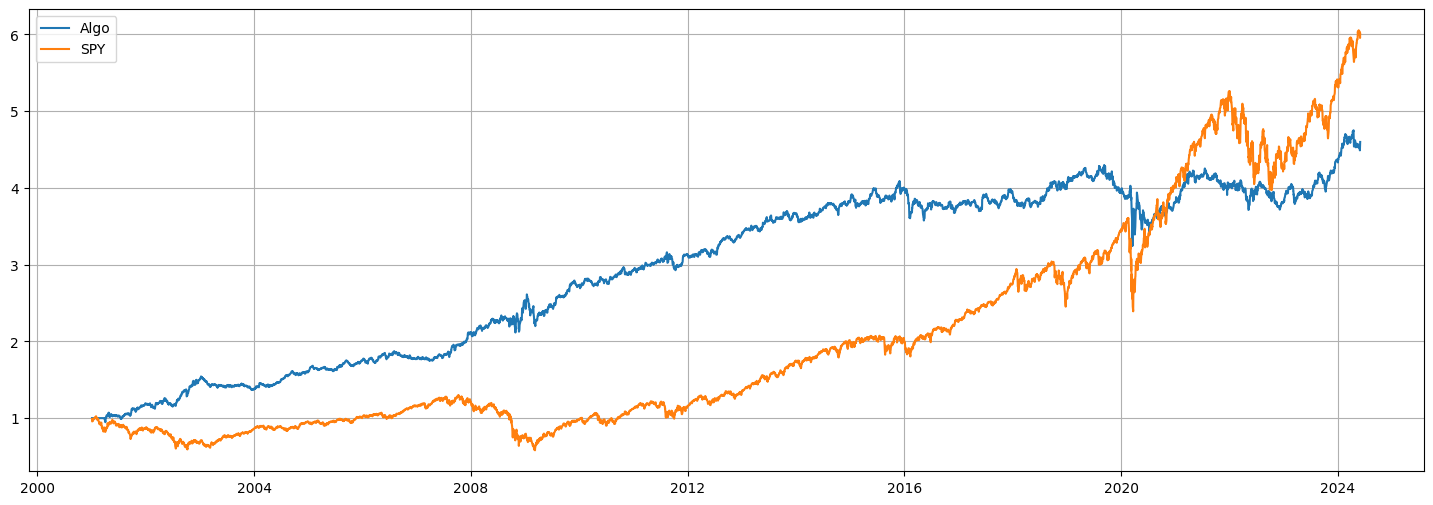

In [203]:
# calculate returns of SPY for comparison
cumret = np.exp(np.nancumsum(ret))
spy_ret = data.xs("SPY", level="Ticker")["Daily Log Return"]
spy_ret = spy_ret.reindex(ret.index)  # align to algo dates
bbh_cumret = np.exp(np.nancumsum(spy_ret))

plt.figure(figsize=(18,6))
plt.grid(True)
plt.plot(ret.index,cumret, label='Algo')
plt.plot(ret.index,bbh_cumret, label='SPY')
plt.legend()
# plt.savefig("15PC_Algo_withoutCosts.png")